In [1]:
import os
import pandas as pd
import numpy as np
import random
import shutil
from shutil import copyfile
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras import Model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
import matplotlib.patches as mpatches

In [9]:
base_dir  = r"C:\Users\Chandini\Downloads\child adult"
os.chdir(base_dir)

In [10]:
mytrain_test_list = []
mylabels_list = []
myitem_list = []
vis_images = []; vis_labels =[]

In [11]:
train_test_list = tf.io.gfile.listdir(base_dir)
for train_test in train_test_list:
    path1 = os.path.join(base_dir, train_test)
    label_list = tf.io.gfile.listdir(path1)
    for label in label_list:
        my_path = os.path.join(path1, label)
        item_files = os.listdir(my_path)

        mytrain_test_list.append(train_test)
        mylabels_list.append(label)
        myitem_list.append(len(item_files))
        my_files = item_files[0:5]
        for file in my_files:
            vis_images.append(os.path.join(my_path, file))
            vis_labels.append(label)
        
pd.DataFrame({'Train Test':mytrain_test_list, 'Labels':mylabels_list, \
              'Number of Items':myitem_list})

Tran Test    Labels  Number of Items
0      test    adults               60
1      test  children               60
2     train    adults              340
3     train  children              340

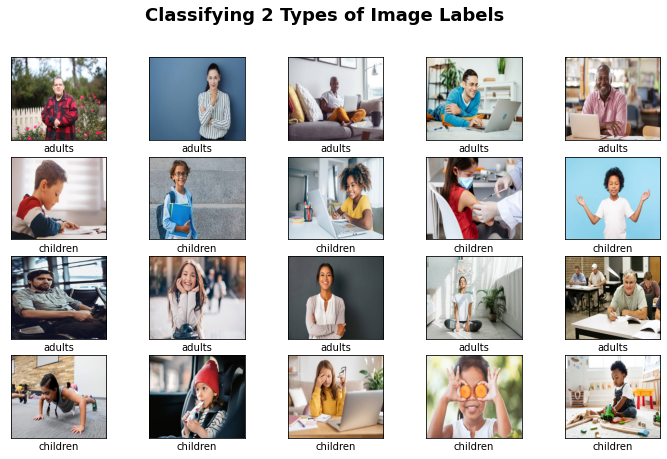

In [12]:
plt.figure(figsize=(12,7))
for i in range(len(vis_labels)):
    plt.subplot(4,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = mpimg.imread(vis_images[i])
    plt.imshow(img)
    plt.xlabel(vis_labels[i])
    plt.suptitle(f"Classifying 2 Types of Image Labels",fontsize=18, fontweight='bold')
plt.show()

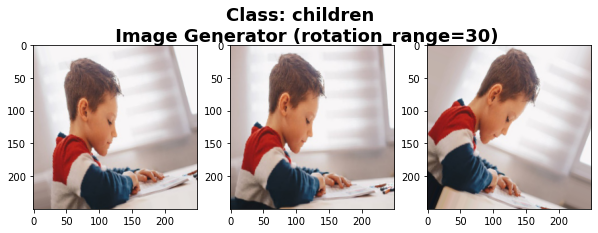

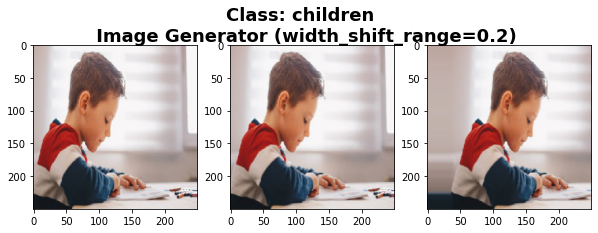

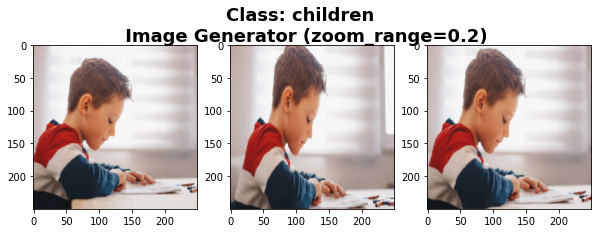

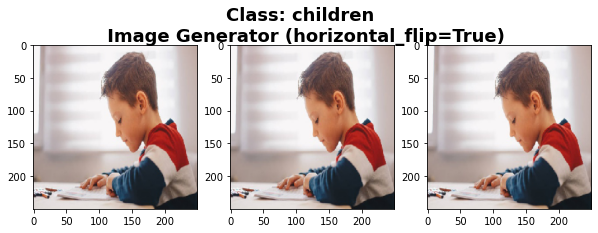

In [19]:
def show_ImageDataGenerator(vis_images, vis_labels, image_index):
    #Loads image in from the set image path
    class_label = vis_labels[image_index]
    img = tf.keras.preprocessing.image.load_img(vis_images[image_index], target_size= (250,250))
    img_tensor = tf.keras.preprocessing.image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)

    #Creates our batch of one image
    def show_image(datagen, param):
        pic = datagen.flow(img_tensor, batch_size =1)
        plt.figure(figsize=(10,3.5))
        #Plots our figures
        for i in range(1,4):
            plt.subplot(1, 3, i)
            batch = pic.next()
            image_ = batch[0].astype('uint8')
            plt.imshow(image_)
        plt.suptitle(f"Class: {class_label} \n Image Generator ({param})",fontsize=18, fontweight='bold')

        plt.show()

    datagen = ImageDataGenerator(rotation_range=30)
    show_image(datagen, "rotation_range=30")

    datagen = ImageDataGenerator(width_shift_range=0.2)
    show_image(datagen, "width_shift_range=0.2")

    datagen = ImageDataGenerator(zoom_range=0.2)
    show_image(datagen, "zoom_range=0.2")

    datagen = ImageDataGenerator(horizontal_flip=True)
    show_image(datagen, "horizontal_flip=True")

show_ImageDataGenerator(vis_images, vis_labels, image_index = 5)

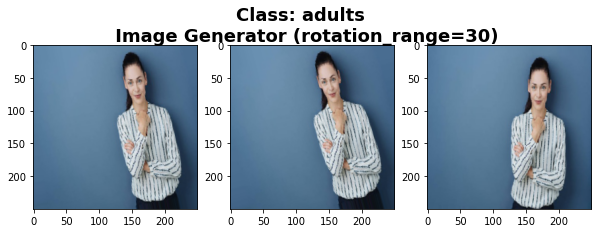

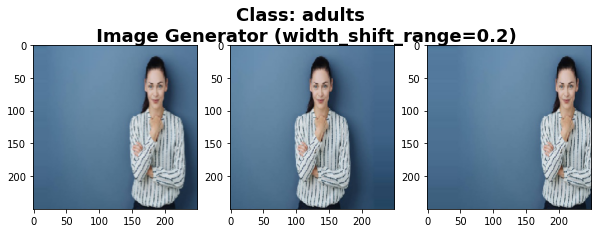

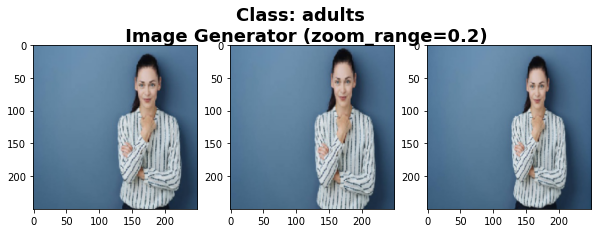

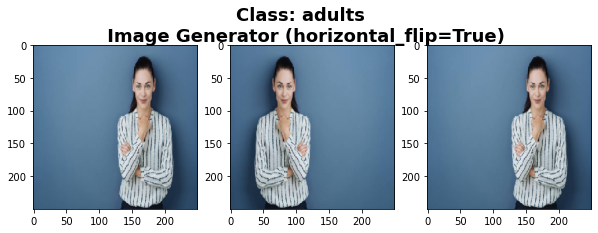

In [30]:
show_ImageDataGenerator(vis_images, vis_labels, image_index = 1)

In [31]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):

    # Instantiate the ImageDataGenerator class (don't forget to set the arguments to augment the images)
    train_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=30,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

    # Pass in the appropriate arguments to the flow_from_directory method
    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=32,
                                                      class_mode='binary',
                                                      target_size=(150, 150))

    # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
    validation_datagen = ImageDataGenerator(rescale=1./255)

    # Pass in the appropriate arguments to the flow_from_directory method
    validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=32,
                                                                class_mode='binary',
                                                                target_size=(150, 150))
    return train_generator, validation_generator

In [32]:
training_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'test')
print(validation_dir)

C:\Users\Chandini\Downloads\child adult\test


In [33]:
train_generator, validation_generator = train_val_generators(training_dir, validation_dir)

Found 680 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


In [34]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(150, 150, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False
last_output = base_model.output
num_trainable_params = sum([w.shape.num_elements() for w in base_model.trainable_weights])

print(f"There are {num_trainable_params:,} trainable parameters in this model.")
print(f"The pretrained model has type: {type(base_model)}")

9420800/9406464 [==============================] - 34s 4us/step
There are 0 trainable parameters in this model.
The pretrained model has type: <class 'keras.engine.functional.Functional'>


In [35]:
def transfer_learning(last_output, pre_trained_model):
    # Flatten the output layer to 1 dimension
    x = tf.keras.layers.Flatten()(last_output)
    # Add a fully connected layer with 1024 hidden units and ReLU activation
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    # Add a dropout rate of 0.6
    x = tf.keras.layers.Dropout(0.6)(x)  
    # Add a final sigmoid layer for classification
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)          
    # Create the complete model by using the Model class
    model = Model(inputs=pre_trained_model.input, outputs=x)
    
    return model

model = transfer_learning(last_output, base_model)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 75, 75, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 75, 75, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 75, 75, 32)   0           ['bn_Conv1[0][0]']           

 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 19, 19, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 19, 19, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 19, 19, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 19, 19, 32)  128         ['block_3_project[0][0]']        
 lization)

 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 10, 10, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 10, 10, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 10, 10, 384)  1536       ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_d

 block_10_project_BN (BatchNorm  (None, 10, 10, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 10, 10, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 10, 10, 576)  2304       ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 10, 10, 576)  0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_

                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 5, 5, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 5, 5, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 5, 5, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 5, 5, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
          

In [36]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))

In [37]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
            loss = 'binary_crossentropy',
            metrics=['accuracy'])

In [38]:
lr_history = model.fit(train_generator,
                       epochs=60,
                       validation_data=validation_generator,
                       callbacks=lr_schedule,
                       verbose=0)

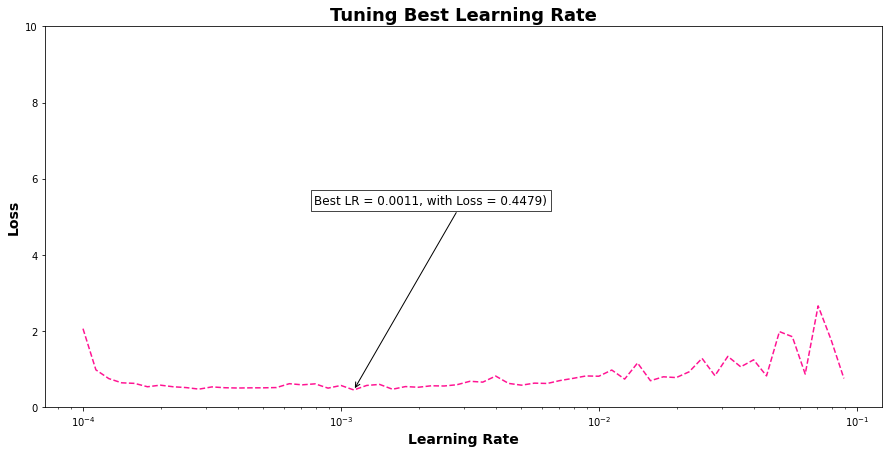

best learn rate = 0.0011220184387639165


In [39]:
def plot_best_learning(lr_history):
    x = lr_history.history["lr"] ; y = lr_history.history["loss"]
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
    def annot_min(x,y, ax=None):
        xmin = x[np.argmin(y)]
        ymin = np.min(y)
        text= f"Best LR = {xmin:.4f}, with Loss = {ymin:.4f})"
        if not ax:
            ax=plt.gca()
        bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
        arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
        kw = dict(xycoords='data',textcoords="axes fraction",
                  arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
        ax.annotate(text, xy=(xmin, ymin), xytext=(0.6,0.56), fontsize=12, **kw)
        return xmin
    xmin = annot_min(x,y,ax)
    ax.semilogx(x, y,ls='dashed', color='deeppink')
    ax.set_title('Tuning Best Learning Rate',fontsize=18, fontweight='bold')
    ax.set_ylabel('Loss',fontsize=14, fontweight='bold')
    ax.set_xlabel('Learning Rate',fontsize=14, fontweight='bold')
    plt.ylim((0, 10))
    plt.show()
    return xmin
    

best_learn_rate = plot_best_learning(lr_history)
print(f"best learn rate = {best_learn_rate}")

In [40]:
model = transfer_learning(last_output, base_model)

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = best_learn_rate),
            loss = 'binary_crossentropy',
            metrics=['accuracy'])

In [41]:
# Define a Callback class that stops training once accuracy reaches 95%
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.95):
            print("\nReached 95% accuracy so cancelling training!")
            self.model.stop_training = True
callbacks = myCallback()

history = model.fit(train_generator,
                    epochs=20,
                    validation_data=validation_generator,
                    callbacks=callbacks)

Epoch 1/20
22/22 [==============================] - 22s 845ms/step - loss: 17.0709 - accuracy: 0.5838 - val_loss: 4.9804 - val_accuracy: 0.7250
Epoch 2/20
22/22 [==============================] - 16s 723ms/step - loss: 6.9034 - accuracy: 0.6971 - val_loss: 3.7713 - val_accuracy: 0.7250
Epoch 3/20
22/22 [==============================] - 18s 811ms/step - loss: 3.4081 - accuracy: 0.7353 - val_loss: 2.3178 - val_accuracy: 0.7917
Epoch 4/20
22/22 [==============================] - 17s 740ms/step - loss: 1.6583 - accuracy: 0.7544 - val_loss: 1.3420 - val_accuracy: 0.7417
Epoch 5/20
22/22 [==============================] - 17s 784ms/step - loss: 0.6809 - accuracy: 0.7618 - val_loss: 0.6686 - val_accuracy: 0.7667
Epoch 6/20
22/22 [==============================] - 17s 747ms/step - loss: 0.5604 - accuracy: 0.7441 - val_loss: 0.5291 - val_accuracy: 0.7750
Epoch 7/20
22/22 [==============================] - 15s 702ms/step - loss: 0.4930 - accuracy: 0.7912 - val_loss: 0.5558 - val_accuracy: 0.766

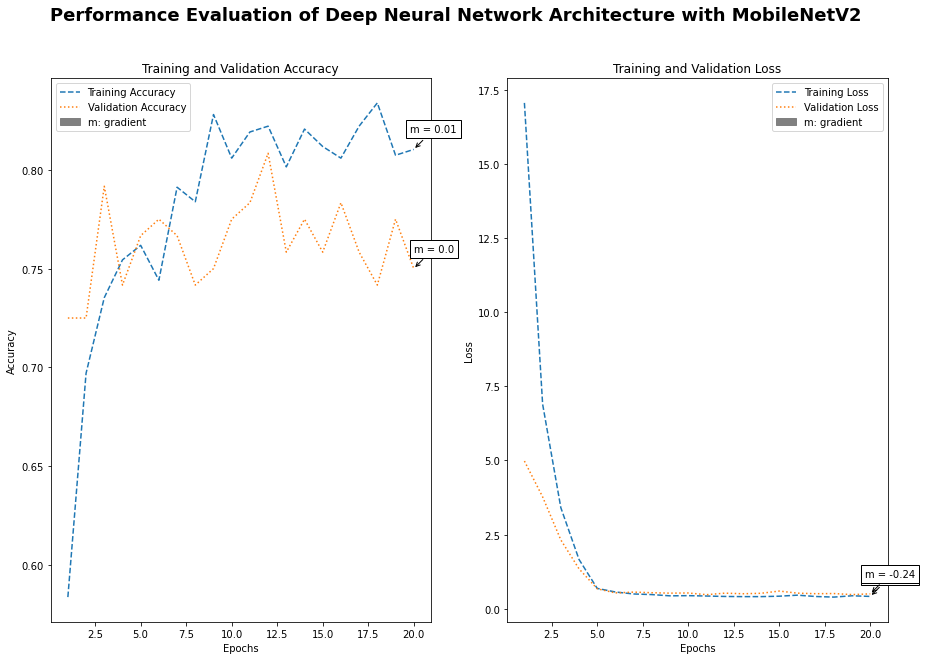

In [42]:
def vis_evaluation(history_dict, model_name):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
    epochs = range(1, len(history_dict['accuracy'])+1)

    def get_gradient(y_arr, epochs):
        return round((y_arr[-1] - y_arr[0]) / (epochs[-1] - epochs[0]),2)

    def vis_sub_evaluation(n, Accuracy, train_acc, val_acc, epochs):
        axs[n].plot(epochs, train_acc, label=f'Training {Accuracy}', ls='--')
        axs[n].plot(epochs, val_acc, label=f'Validation {Accuracy}', ls='dotted')

        axs[n].set_title(f'Training and Validation {Accuracy}')
        axs[n].set_xlabel('Epochs')
        axs[n].set_ylabel(Accuracy)
        
        handles, labels = axs[n].get_legend_handles_labels()
        m_patch = mpatches.Patch(color='grey',label='m: gradient')
        handles.append(m_patch) 
        axs[n].legend(handles=handles)
        
        def annotate_box(train_acc):
            return AnnotationBbox(TextArea(f"m = {get_gradient(train_acc, epochs)}"), (epochs[-1], train_acc[-1]),
                            xybox=(20, 20),
                            xycoords='data',
                            boxcoords="offset points",
                            arrowprops=dict(arrowstyle="->"))
        axs[n].add_artist(annotate_box(train_acc))
        axs[n].add_artist(annotate_box(val_acc))

    train_acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    vis_sub_evaluation(0, 'Accuracy', train_acc, val_acc, epochs)

    train_loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    vis_sub_evaluation(1, 'Loss', train_loss, val_loss, epochs)
    
    plt.suptitle(f"Performance Evaluation of {model_name}",fontsize=18, fontweight='bold')
    plt.show()
    
history_dict = history.history
vis_evaluation(history_dict, 'Deep Neural Network Architecture with MobileNetV2')

C:\Users\Chandini\AppData\Local\Temp/ipykernel_8160/3460212887.py:44: RuntimeWarning: divide by zero encountered in true_divide
  x /= x.std ()
C:\Users\Chandini\AppData\Local\Temp/ipykernel_8160/3460212887.py:44: RuntimeWarning: invalid value encountered in true_divide
  x /= x.std ()
C:\Users\Chandini\AppData\Local\Temp/ipykernel_8160/3460212887.py:54: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure( figsize=(scale * n_features, scale) )


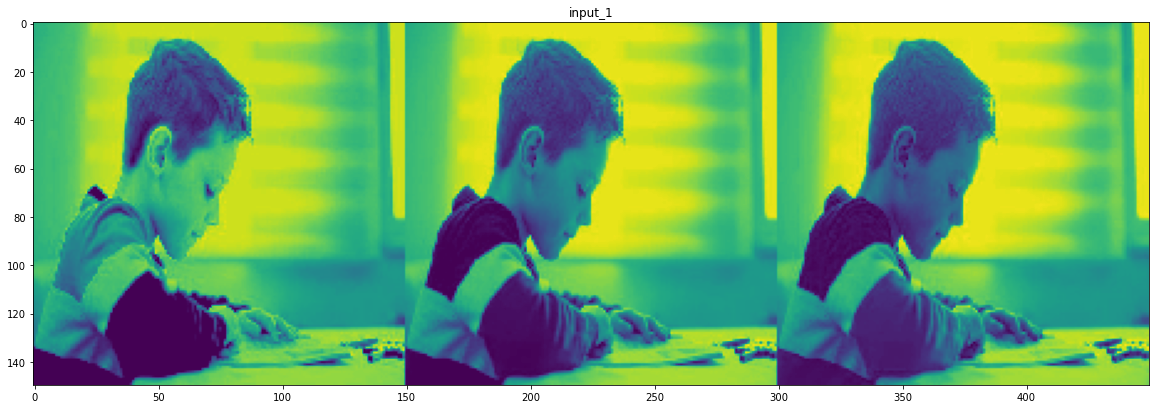

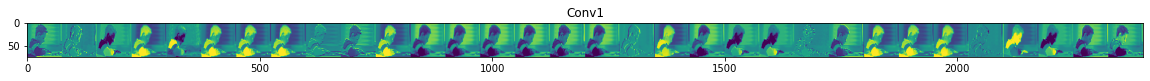

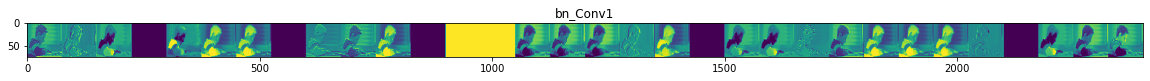

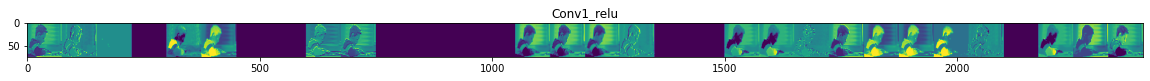

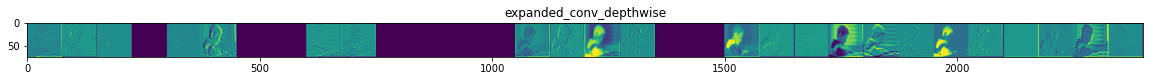

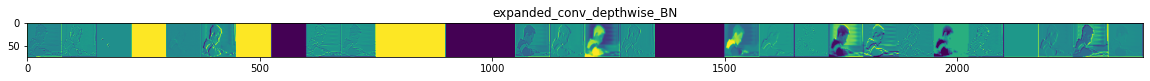

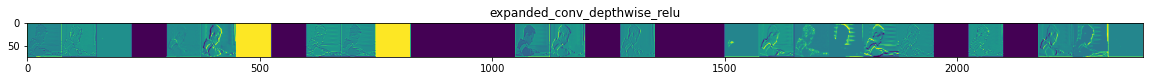

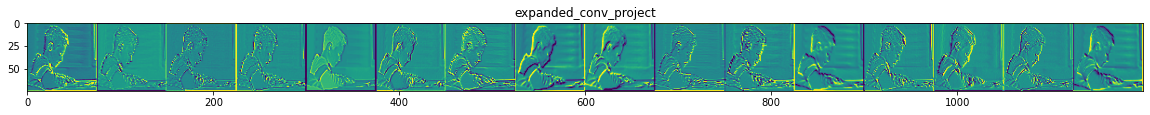

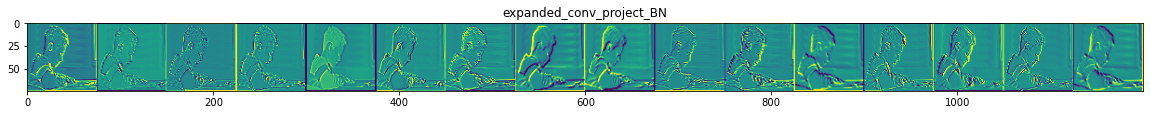

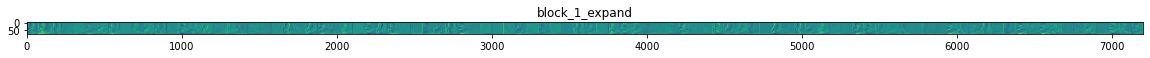

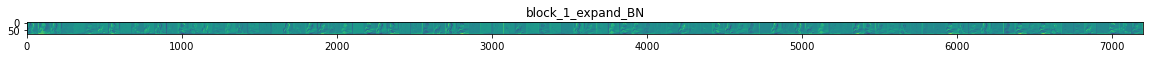

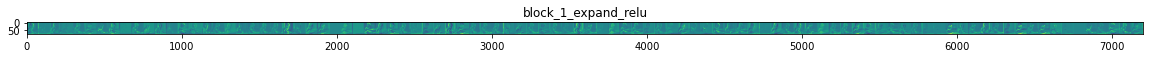

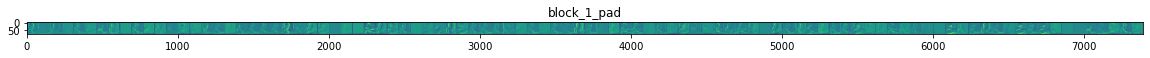

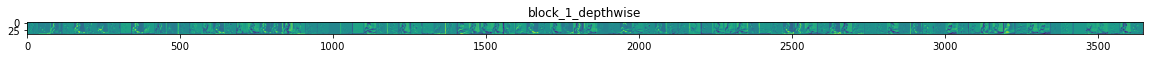

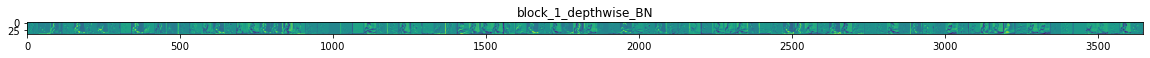

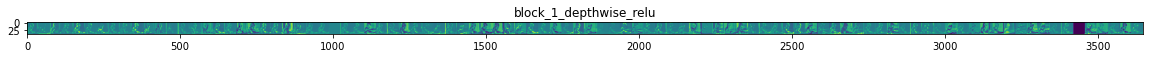

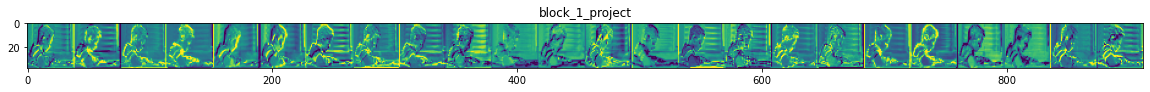

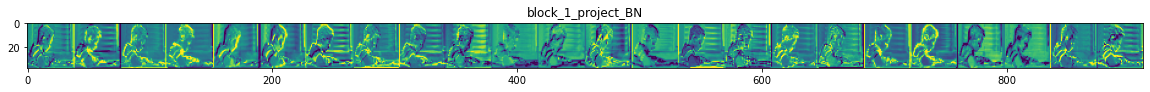

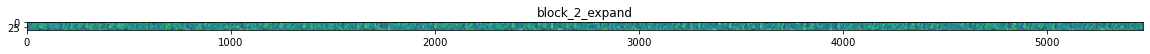

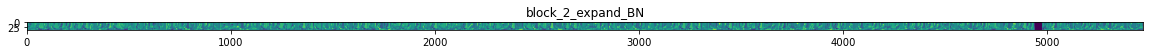

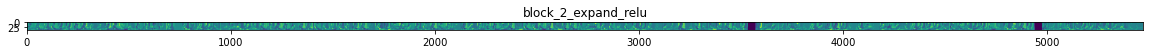

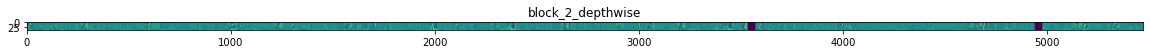

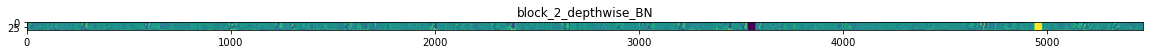

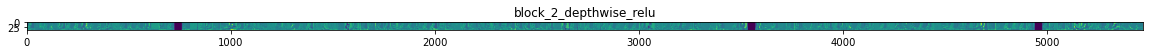

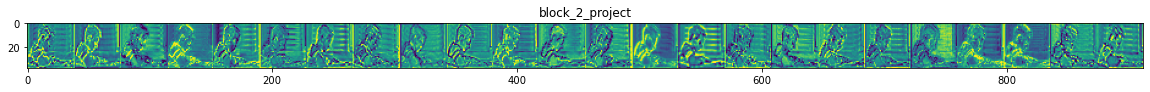

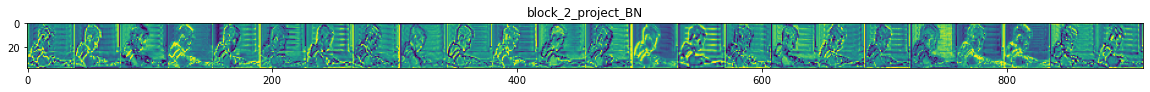

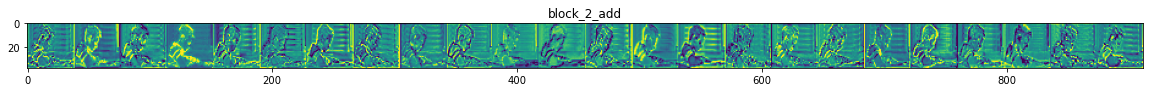

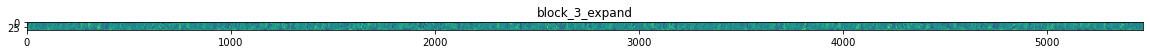

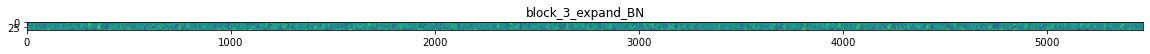

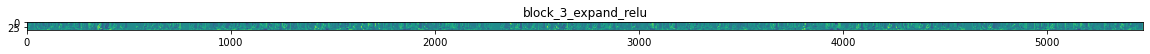

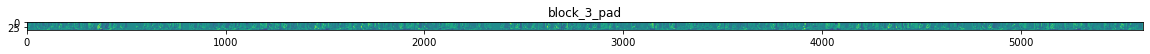

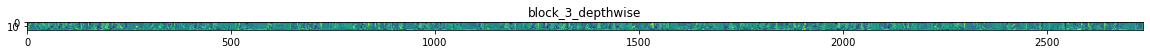

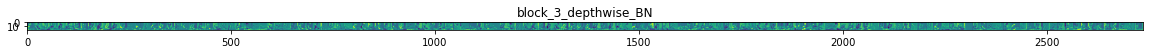

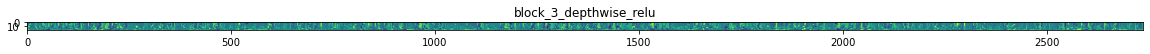

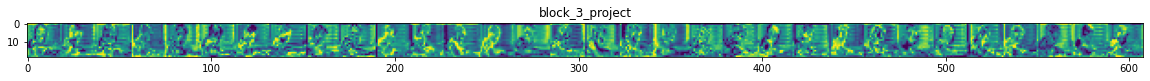

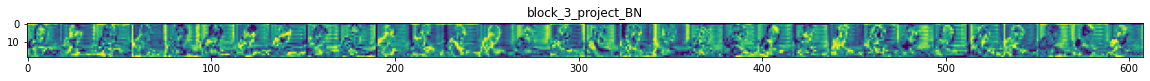

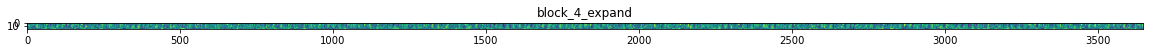

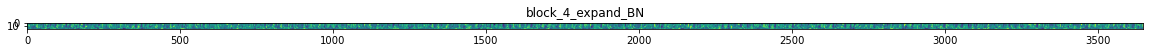

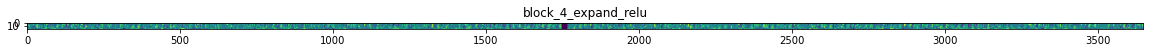

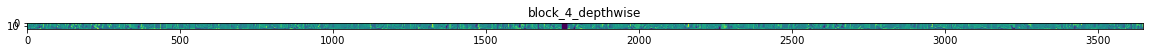

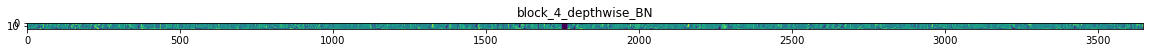

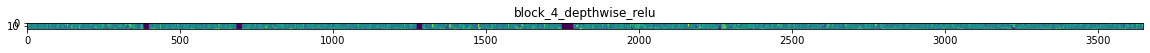

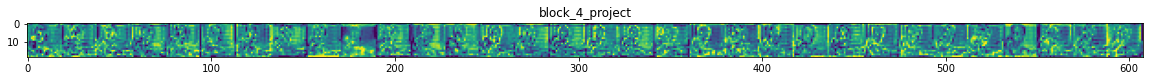

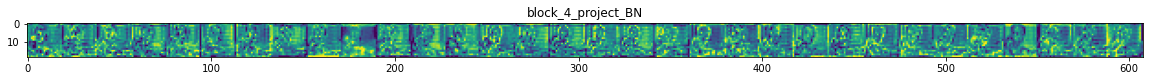

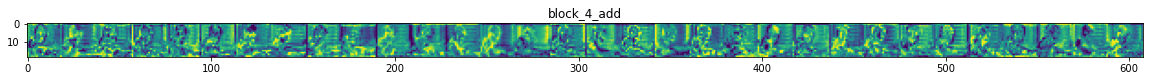

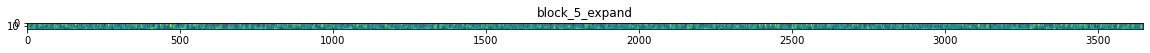

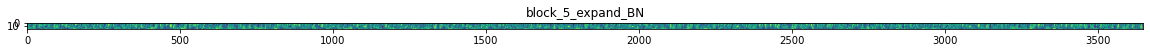

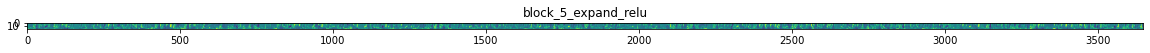

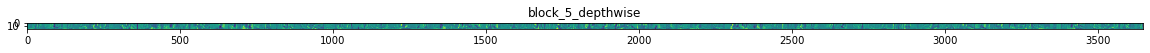

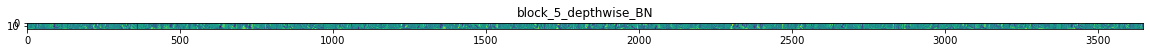

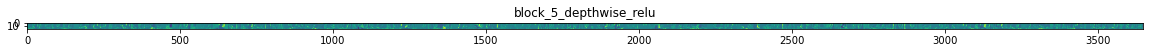

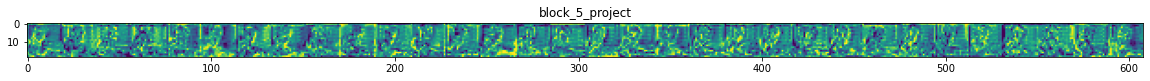

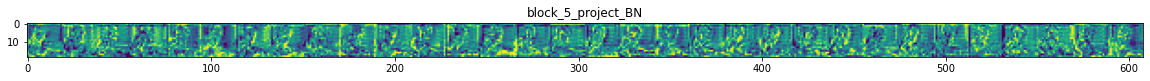

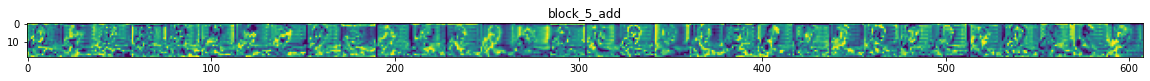

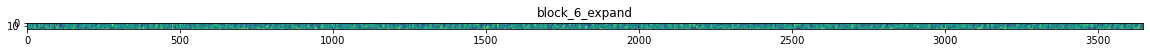

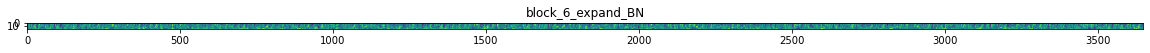

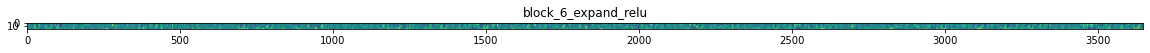

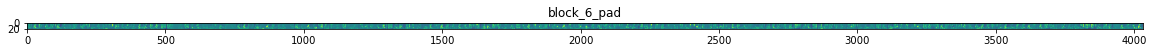

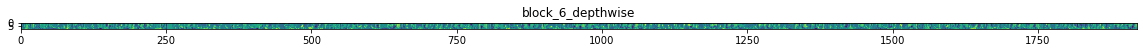

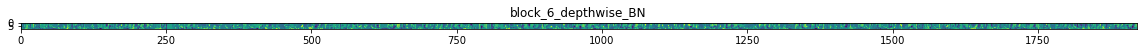

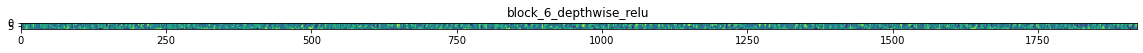

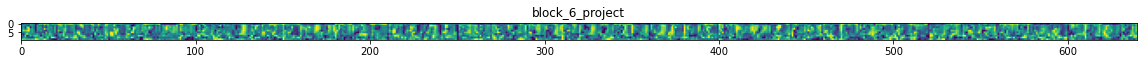

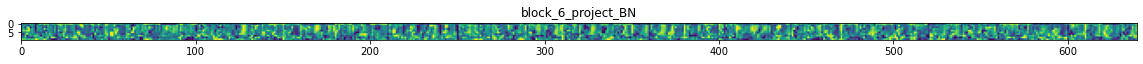

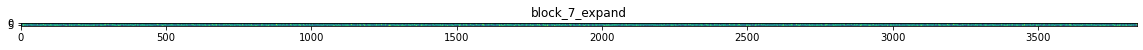

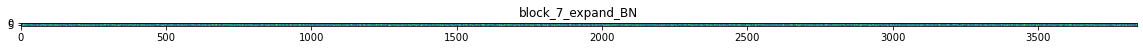

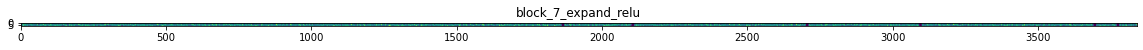

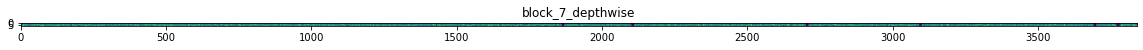

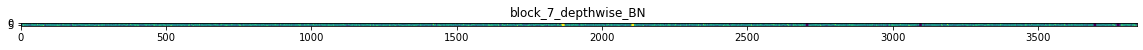

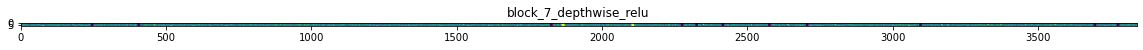

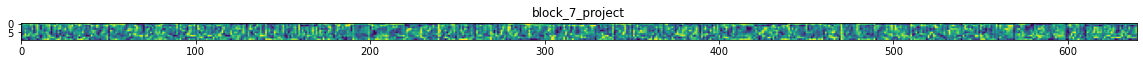

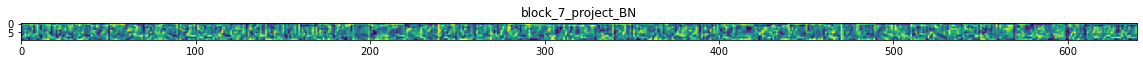

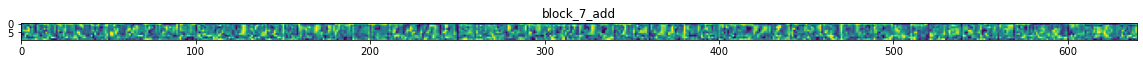

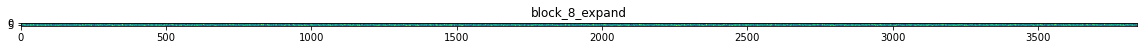

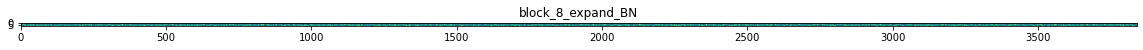

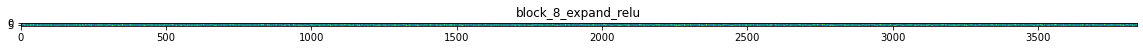

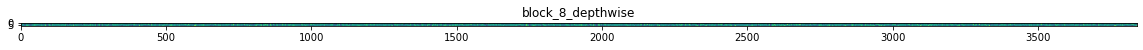

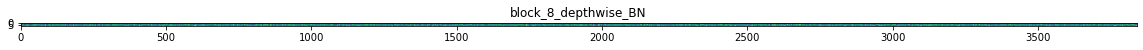

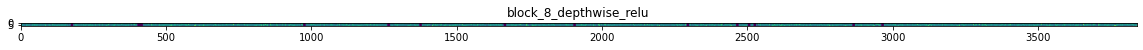

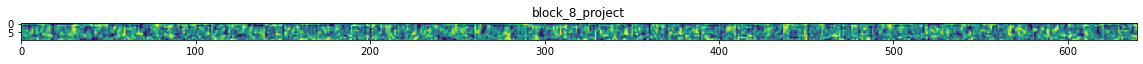

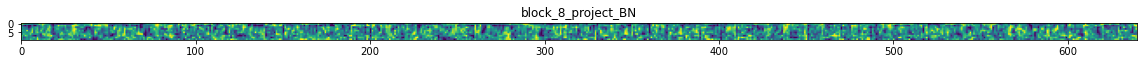

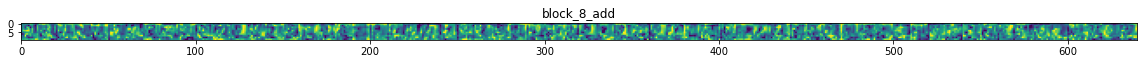

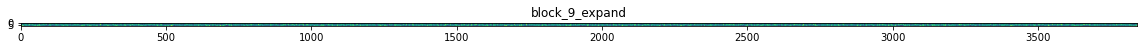

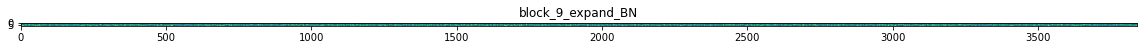

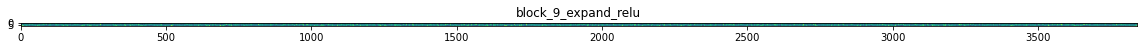

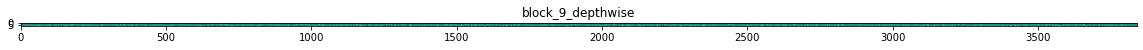

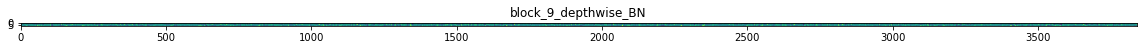

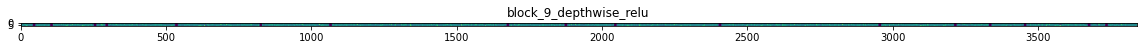

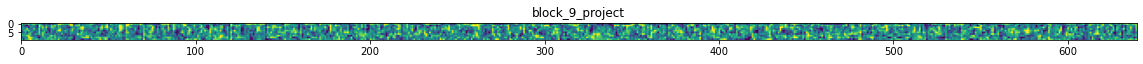

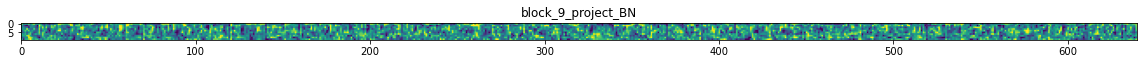

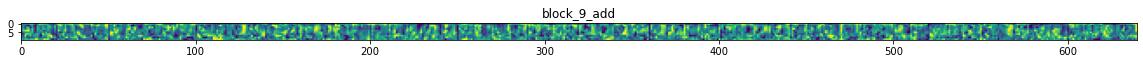

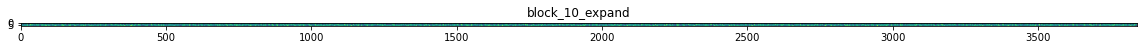

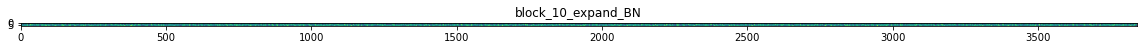

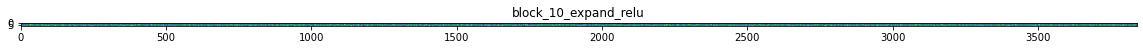

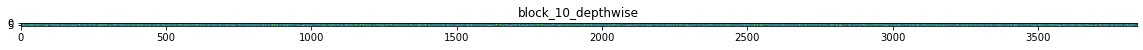

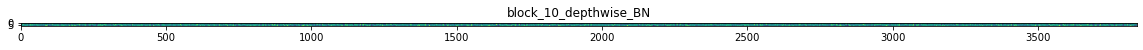

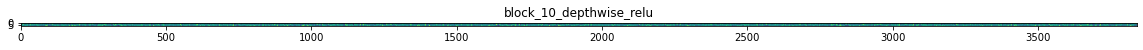

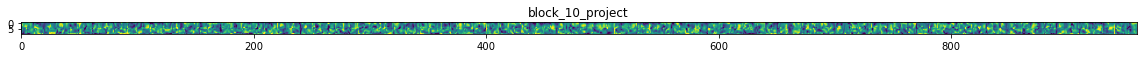

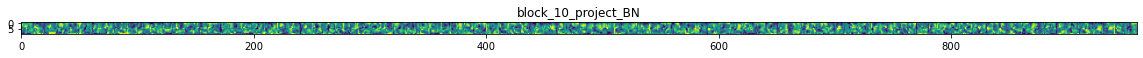

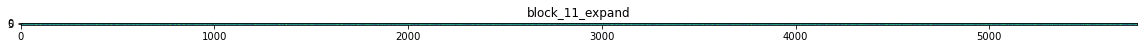

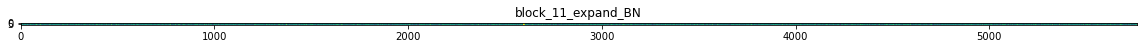

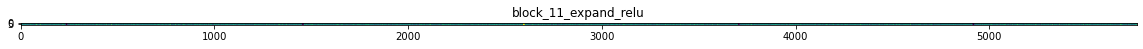

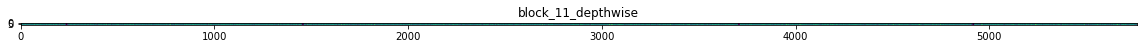

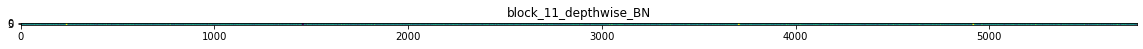

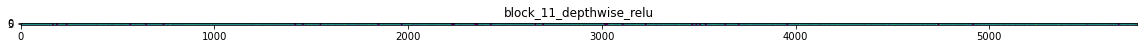

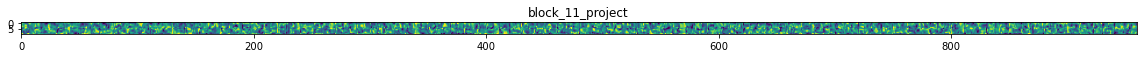

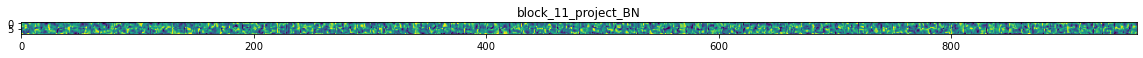

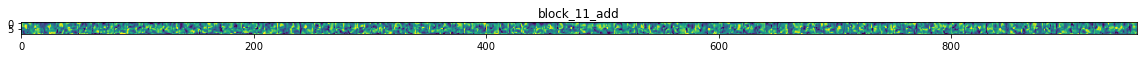

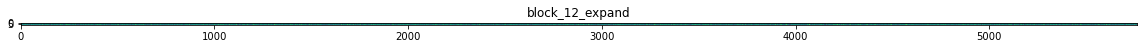

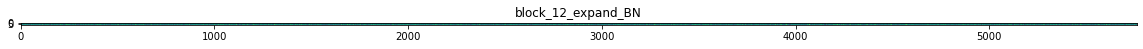

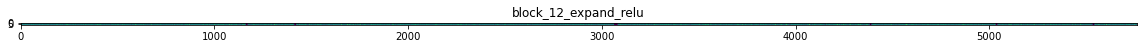

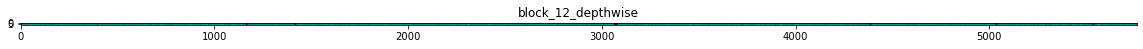

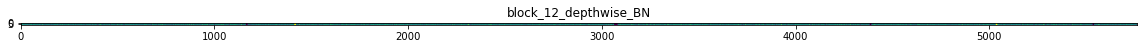

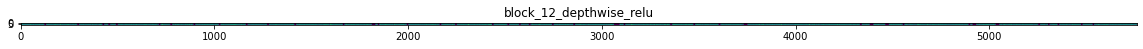

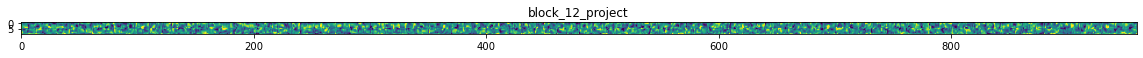

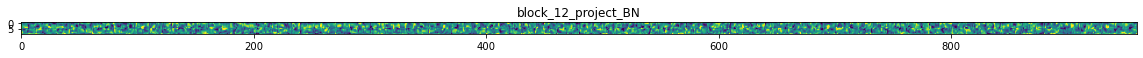

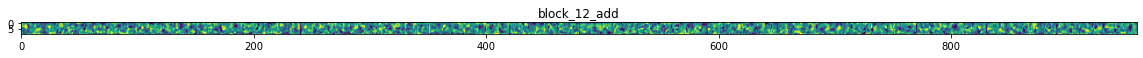

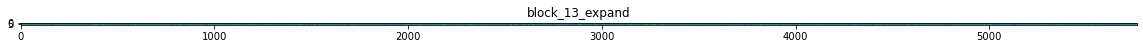

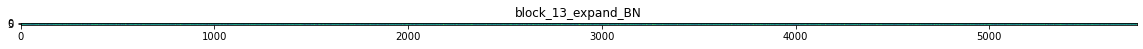

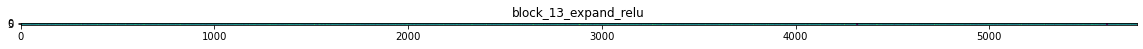

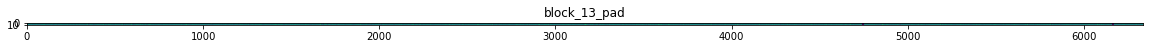

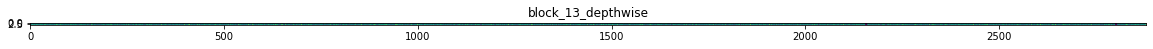

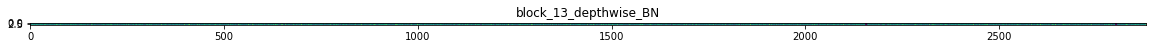

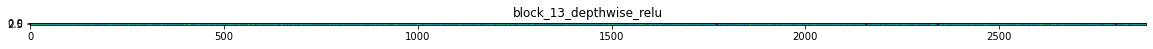

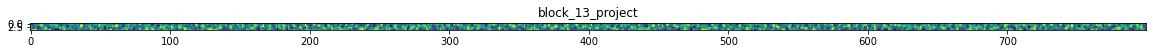

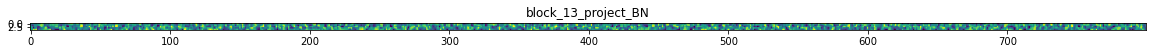

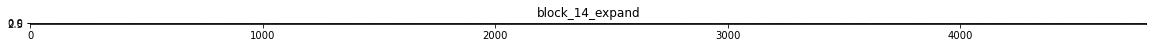

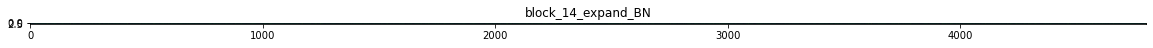

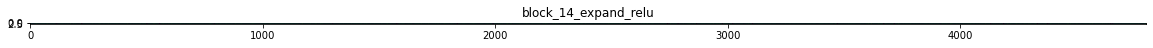

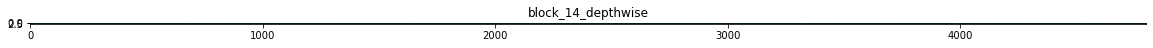

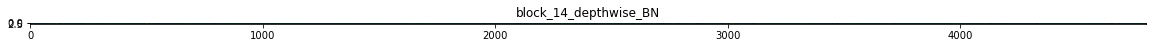

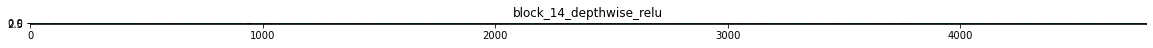

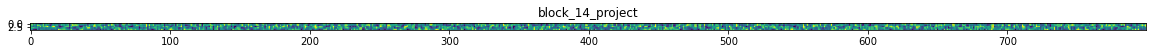

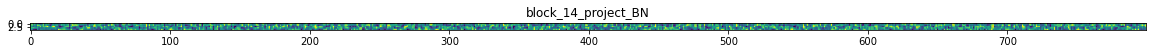

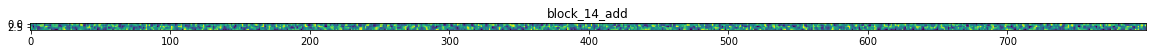

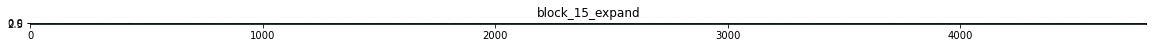

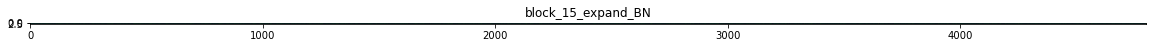

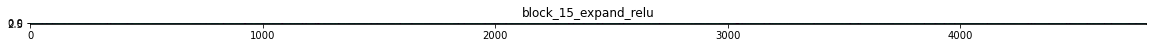

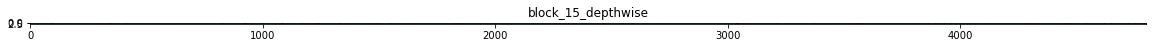

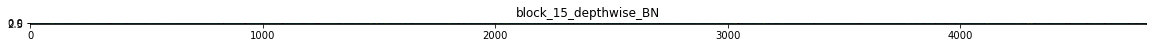

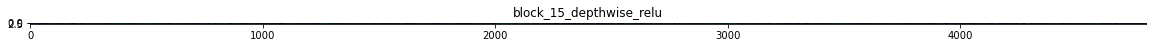

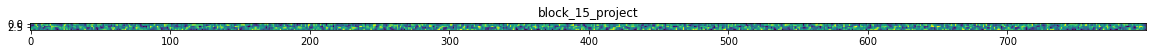

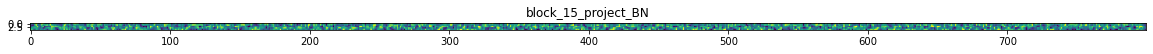

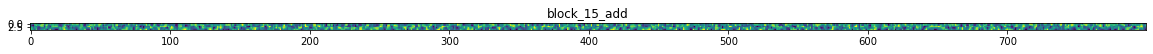

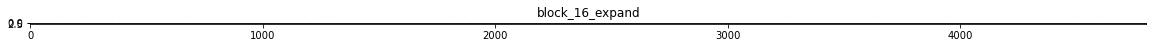

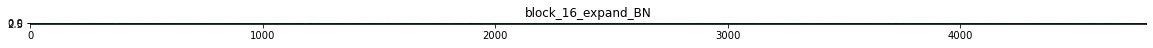

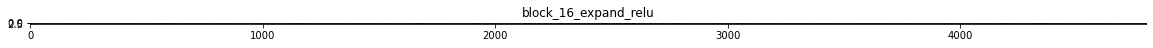

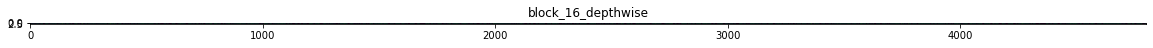

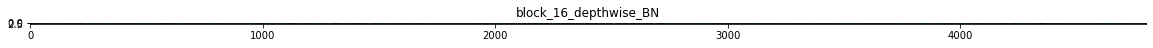

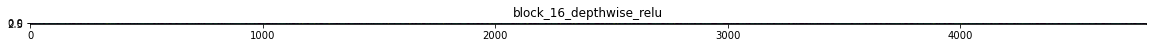

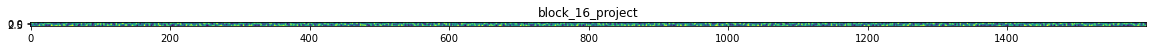

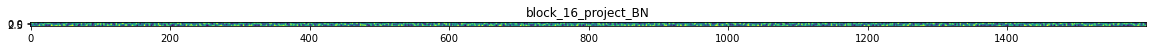

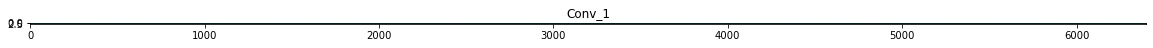

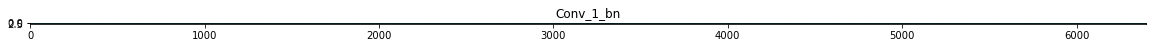

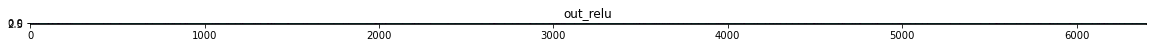

In [43]:
# Define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model
successive_outputs = [layer.output for layer in model.layers]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Prepare a random input image from the training set.
adult_img_files = vis_images[:5]
child_img_files = vis_images[5:10]
img_path = random.choice(adult_img_files + child_img_files)
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

# Scale by 1/255
x /= 255.0

# Run the image through the network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so you can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Display the representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
  if len(feature_map.shape) == 4:
    
    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # Tile the images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
        x  = feature_map[0, :, :, i]
        x -= x.mean()
        x /= x.std ()
        x *=  64
        x += 128
        x  = np.clip(x, 0, 255).astype('uint8')
        display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------
    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 

 This image most likely belongs to 'children' with a 64.65 percent confidence.


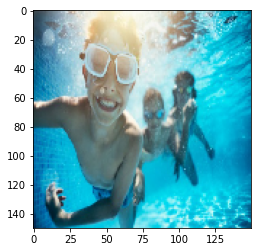

In [47]:
def make_your_prediction(YOUR_IMAGE_PATH = None):
    if YOUR_IMAGE_PATH == None:
        YOUR_IMAGE_PATH = r"C:\Users\Chandini\Downloads\child adult\test\children\5.jpg" 
    
    img = image.load_img(YOUR_IMAGE_PATH, target_size=(150, 150))
    plt.imshow(img)
    x = image.img_to_array(img)
    x /= 255
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    score = tf.nn.sigmoid(classes[0])

    class_name = train_generator.class_indices
    class_name_inverted = {y: x for x, y in class_name.items()}

    if classes[0]>0.5:
        print(f" This image most likely belongs to '{class_name_inverted[1]}' with a {100 * np.max(score):.2f} percent confidence.")
    else:
        print(f" This image most likely belongs to '{class_name_inverted[0]}' with a {100 * np.max(score):.2f} percent confidence.")

make_your_prediction(YOUR_IMAGE_PATH = None)